In [2]:
#Check if colab is running
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
  %tensorflow_version 2.x

#import TF
import tensorflow as tf
from platform import python_version
print("Tensorflow version", tf.__version__)
print("Python version =",python_version())

Tensorflow version 2.11.1
Python version = 3.10.10


In [3]:
import numpy as np
import time 
from scipy.spatial.distance import cdist

import matplotlib.pyplot as plt

import seaborn as sns

import pandas as pd
from pandas.plotting import scatter_matrix
import geopandas
#%pip install geodatasets
from geodatasets import get_path

from IPython.display import Image
from keras.utils.vis_utils import plot_model

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import LSTM, SimpleRNN, GRU
from tensorflow.keras.layers import Embedding
from keras.layers import Reshape
from keras.callbacks import LearningRateScheduler

from tensorflow.keras.optimizers import Adam
from tensorflow import keras
from tensorflow.keras import optimizers

## establish functions for evalulation when using dropout:

In [4]:
#History for dropout:
from tensorflow.keras.callbacks import Callback

class HistoryEpoch(Callback):
    def __init__(self, data):
        self.data = data

    def on_train_begin(self, logs={}):
        self.loss = []
        self.acc = []

    def on_epoch_end(self, epoch, logs={}):
        x, y = self.data
        l, a = self.model.evaluate(x, y, verbose=0)
        self.loss.append(l)
        self.acc.append(a)
        
def plot_history(network_history):
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(network_history.history['loss'])
    plt.plot(network_history.history['val_loss'])
    plt.legend(['Training', 'Validation'])

    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('mae')
    plt.plot(network_history.history['mae'])
    plt.plot(network_history.history['val_mae'])
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()

def scheduler(epoch, lr):
    if epoch < 100:
        return lr
    else:
        return lr * tf.math.exp(-0.05)

# Loading Data:

In [36]:
df_main = pd.read_csv("RONA_DATA2", sep='\t')
df_main = df_main.drop(['Unnamed: 0'], axis = 1)
df_main = df_main.sort_values(['date'], ascending = True)
df_main

,confirmed,tmin,tmax,tavg,pres,date,city,population
0,0,-5.5,5.0,-1.2,1030.9,1.579651,1294,10973.0
1742,0,-8.9,4.4,-2.8,1031.3,1.579651,275,73745.0
1743,0,-11.1,2.8,-5.2,1031.6,1.579651,325,9519.0
1744,0,-6.2,0.4,-3.9,1030.3,1.579651,414,35038.0
1745,0,-4.3,10.0,1.5,1027.9,1.579651,1399,60962.0
...,...,...,...,...,...,...,...,...
130291,0,3.9,9.4,8.2,1020.3,1.583971,1518,22340.0
130292,0,0.0,8.9,5.6,1021.2,1.583971,972,9122.0
130293,503,5.8,11.0,8.6,1007.9,1.583971,552,31334.0
130295,0,7.8,17.8,11.8,1017.9,1.583971,2437,10871.0


In [38]:
counter1 = 0
for i in df_main['city'].unique():
    if np.array(df_main[df_main['city']==i]).shape == (51, 8):
        counter1 += 1
x = np.zeros((counter1+1, 40, 8))
y = np.zeros((counter1+1, 11))

counter2 = 0
for i in df_main['city'].unique():
    if np.array(df_main[df_main['city']==i]).shape == (51, 8):
        x[counter2] = np.array(df_main[df_main['city']==i])[:40]
        y[counter2] = np.array(df_main[df_main['city']==i])[-11:, 0]
        counter2 += 1


In [12]:
X = x
Y = y

scaler = RobustScaler(quantile_range=(25, 75))
scaler2 = StandardScaler()
scaler3 = MinMaxScaler(feature_range=(-10, 10))
#X = scaler.fit_transform(X)
#X = scaler2.fit_transform(X.reshape(-1, X.shape[-1])).reshape(X.shape)

scaler_y = MinMaxScaler(feature_range=(0.1, 0.9))  # feature range just for trying things out
#Y = scaler2.fit_transform(Y)
#Y = scaler_y.fit_transform(Y)


X_train, X_test, y_train, y_test = train_test_split(X, Y,  test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,  test_size=0.2, random_state=1)

X_test = scaler2.fit_transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)
X_train = scaler2.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_val = scaler2.fit_transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape)


# checking correlation

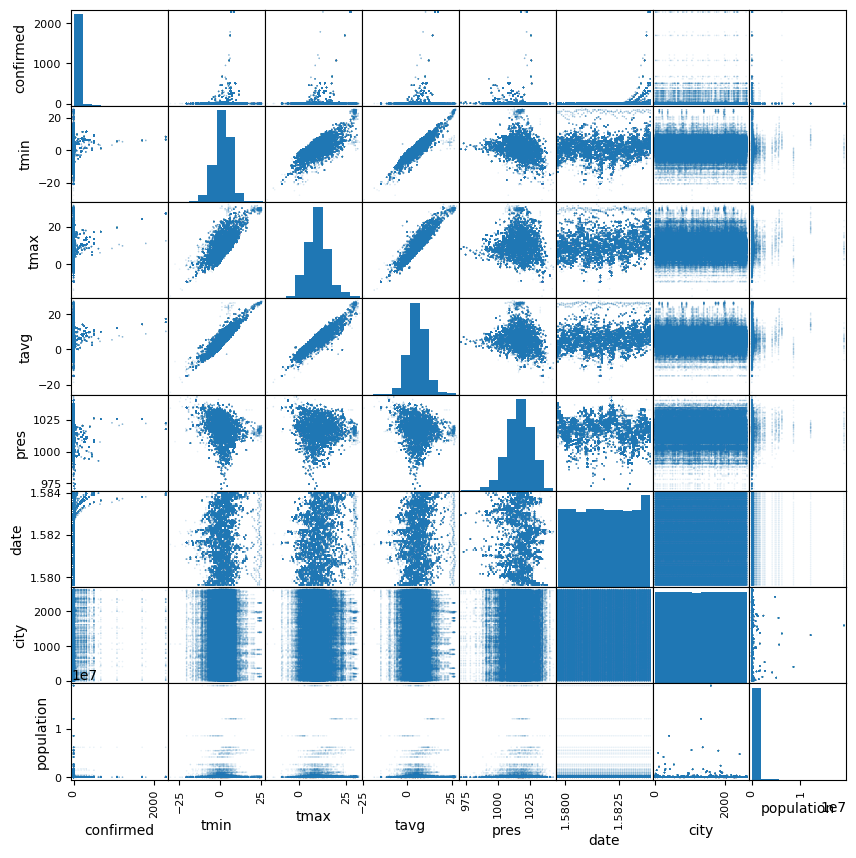

In [9]:
scatter_matrix(df_main, alpha=0.1, figsize=(10, 10), s=5)
#plt.show()
plt.savefig("scatter.png")

data done
# MODEL TESTING

### SimpleRNN:

In [22]:
early_stop = EarlyStopping(monitor='val_loss', patience=15, verbose=1)
learning = tf.keras.callbacks.LearningRateScheduler(scheduler)

modelS = Sequential()


ac =  'LeakyReLU'

dropout = 0.3
learning_rate = 0.01

optimizer = Adam(learning_rate=learning_rate)

batches = 4
embedding_vecor_length = 10
loss = 0

modelS.add(SimpleRNN(64))

modelS.add(Dense(units=11, activation= 'softplus'))

train_hist=HistoryEpoch((X_train, y_train))
val_hist=HistoryEpoch((X_val, y_val))
#test_hist=HistoryEpoch((X_test, y_test))

modelS.compile(loss='mse', optimizer=optimizer, metrics=['mae'])
modelS.build(X_train.shape)
modelS.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_3 (SimpleRNN)    (1283, 64)                4672      
                                                                 
 dense_3 (Dense)             (1283, 11)                715       
                                                                 
Total params: 5,387
Trainable params: 5,387
Non-trainable params: 0
_________________________________________________________________


In [23]:
starttime = time.time()
history_dropout = modelS.fit(X_train,y_train,
                                    batch_size=batches, epochs = 150, verbose=1,
                                    validation_data=(X_val, y_val),
                                    callbacks=[val_hist, train_hist, early_stop, learning])
laptime_simple = round((time.time() - starttime), 2)
print(laptime_simple)

Epoch 1/150
321/321 [==============================] - 2s 4ms/step - loss: 55163.3281 - mae: 61.3717 - val_loss: 49735.3125 - val_mae: 64.4156 - lr: 0.0100
Epoch 2/150
321/321 [==============================] - 1s 3ms/step - loss: 46116.5859 - mae: 52.4028 - val_loss: 47749.8789 - val_mae: 94.8362 - lr: 0.0100
Epoch 3/150
321/321 [==============================] - 1s 3ms/step - loss: 40020.0078 - mae: 48.2937 - val_loss: 40947.8164 - val_mae: 70.0710 - lr: 0.0100
Epoch 4/150
321/321 [==============================] - 1s 3ms/step - loss: 34914.7695 - mae: 38.0944 - val_loss: 34454.0625 - val_mae: 47.7854 - lr: 0.0100
Epoch 5/150
321/321 [==============================] - 1s 3ms/step - loss: 31011.1387 - mae: 32.2567 - val_loss: 30304.7578 - val_mae: 37.3725 - lr: 0.0100
Epoch 6/150
321/321 [==============================] - 1s 3ms/step - loss: 28288.0938 - mae: 29.6907 - val_loss: 28057.5430 - val_mae: 35.9815 - lr: 0.0100
Epoch 7/150
321/321 [==============================] - 1s 3ms/st

Epoch 54/150
321/321 [==============================] - 1s 3ms/step - loss: 1143.8508 - mae: 7.1102 - val_loss: 1429.6128 - val_mae: 7.8119 - lr: 0.0062
Epoch 55/150
321/321 [==============================] - 1s 3ms/step - loss: 1117.5828 - mae: 7.4346 - val_loss: 1167.8820 - val_mae: 7.4595 - lr: 0.0061
Epoch 56/150
321/321 [==============================] - 1s 3ms/step - loss: 962.0364 - mae: 6.5698 - val_loss: 1055.3740 - val_mae: 7.0849 - lr: 0.0059
Epoch 57/150
321/321 [==============================] - 1s 3ms/step - loss: 846.1707 - mae: 6.3463 - val_loss: 1054.2100 - val_mae: 7.4454 - lr: 0.0058
Epoch 58/150
321/321 [==============================] - 1s 3ms/step - loss: 779.0623 - mae: 5.9276 - val_loss: 1099.6882 - val_mae: 8.2055 - lr: 0.0057
Epoch 59/150
321/321 [==============================] - 1s 4ms/step - loss: 738.1350 - mae: 5.9195 - val_loss: 1029.1512 - val_mae: 7.6775 - lr: 0.0056
Epoch 60/150
321/321 [==============================] - 1s 3ms/step - loss: 696.3106 -

In [24]:
simple_train = train_hist.loss
simple_val = val_hist.loss

### GRU:

In [26]:
early_stop = EarlyStopping(monitor='val_loss', patience=15, verbose=1)
learning = tf.keras.callbacks.LearningRateScheduler(scheduler)

modelG = Sequential()


ac =  'LeakyReLU'

dropout = 0.3
learning_rate = 0.01

optimizer = Adam(learning_rate=learning_rate)

batches = 4
embedding_vecor_length = 10
loss = 0

modelG.add(GRU(64))

modelG.add(Dense(units=11, activation= 'softplus'))

train_hist=HistoryEpoch((X_train, y_train))
val_hist=HistoryEpoch((X_val, y_val))
#test_hist=HistoryEpoch((X_test, y_test))

modelG.compile(loss='mse', optimizer=optimizer, metrics=['mae'])
modelG.build(X_train.shape)
modelG.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (1283, 64)                14208     
                                                                 
 dense_4 (Dense)             (1283, 11)                715       
                                                                 
Total params: 14,923
Trainable params: 14,923
Non-trainable params: 0
_________________________________________________________________


In [27]:
starttime = time.time()
history_dropout = modelG.fit(X_train,y_train,
                                    batch_size=batches, epochs = 150, verbose=1,
                                    validation_data=(X_val, y_val),
                                    callbacks=[val_hist, train_hist, early_stop, learning])
laptime_GRU = round((time.time() - starttime), 2)
print(laptime_GRU)

Epoch 1/150
321/321 [==============================] - 4s 9ms/step - loss: 53431.5586 - mae: 58.3537 - val_loss: 48027.3984 - val_mae: 56.4120 - lr: 0.0100
Epoch 2/150
321/321 [==============================] - 2s 8ms/step - loss: 44344.6602 - mae: 45.9663 - val_loss: 40416.7969 - val_mae: 42.3827 - lr: 0.0100
Epoch 3/150
321/321 [==============================] - 2s 7ms/step - loss: 37744.0703 - mae: 37.9233 - val_loss: 35162.3203 - val_mae: 37.7136 - lr: 0.0100
Epoch 4/150
321/321 [==============================] - 2s 8ms/step - loss: 33083.5820 - mae: 32.5980 - val_loss: 31590.5977 - val_mae: 34.5360 - lr: 0.0100
Epoch 5/150
321/321 [==============================] - 2s 7ms/step - loss: 29857.7305 - mae: 30.6687 - val_loss: 28470.8340 - val_mae: 28.5232 - lr: 0.0100
Epoch 6/150
321/321 [==============================] - 2s 8ms/step - loss: 27305.9648 - mae: 28.3629 - val_loss: 26664.6602 - val_mae: 26.3553 - lr: 0.0100
Epoch 7/150
321/321 [==============================] - 2s 8ms/st

In [28]:
GRU_train = train_hist.loss
GRU_val = val_hist.loss

In [46]:
early_stop = EarlyStopping(monitor='val_loss', patience=15, verbose=1)
learning = tf.keras.callbacks.LearningRateScheduler(scheduler)

modelL = Sequential()


ac =  'LeakyReLU'

dropout = 0.3
learning_rate = 0.002

optimizer = Adam(learning_rate=learning_rate)

batches = 4
embedding_vecor_length = 10
loss = 0

modelL.add(LSTM(64))
modelL.add(Dropout(0.3))

modelL.add(Dense(units=11, activation= 'softplus'))

train_hist=HistoryEpoch((X_train, y_train))
val_hist=HistoryEpoch((X_val, y_val))
#test_hist=HistoryEpoch((X_test, y_test))

modelL.compile(loss='mse', optimizer=optimizer, metrics=['mae'])
modelL.build(X_train.shape)
modelL.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (1283, 64)                18688     
                                                                 
 dropout_3 (Dropout)         (1283, 64)                0         
                                                                 
 dense_10 (Dense)            (1283, 11)                715       
                                                                 
Total params: 19,403
Trainable params: 19,403
Non-trainable params: 0
_________________________________________________________________


In [47]:
starttime = time.time()
history_dropout = modelL.fit(X_train,y_train,
                                    batch_size=batches, epochs = 150, verbose=1,
                                    validation_data=(X_val, y_val),
                                    callbacks=[val_hist, train_hist, early_stop, learning])
laptime_LSTM = round((time.time() - starttime), 2)
print(laptime_LSTM)

Epoch 1/150
321/321 [==============================] - 4s 8ms/step - loss: 57432.6055 - mae: 64.9440 - val_loss: 55623.4336 - val_mae: 64.1358 - lr: 0.0020
Epoch 2/150
321/321 [==============================] - 2s 7ms/step - loss: 55473.8008 - mae: 64.3415 - val_loss: 53834.1797 - val_mae: 66.3381 - lr: 0.0020
Epoch 3/150
321/321 [==============================] - 2s 8ms/step - loss: 53618.1250 - mae: 63.7043 - val_loss: 52001.7148 - val_mae: 66.1169 - lr: 0.0020
Epoch 4/150
321/321 [==============================] - 2s 7ms/step - loss: 51374.0625 - mae: 55.5610 - val_loss: 51193.7266 - val_mae: 79.3638 - lr: 0.0020
Epoch 5/150
321/321 [==============================] - 2s 8ms/step - loss: 51109.1523 - mae: 72.2289 - val_loss: 50393.4609 - val_mae: 78.3375 - lr: 0.0020
Epoch 6/150
321/321 [==============================] - 2s 8ms/step - loss: 49231.7969 - mae: 61.9247 - val_loss: 47430.3750 - val_mae: 53.6532 - lr: 0.0020
Epoch 7/150
321/321 [==============================] - 2s 8ms/st

321/321 [==============================] - 2s 8ms/step - loss: 5670.5356 - mae: 12.3705 - val_loss: 6596.2134 - val_mae: 13.4460 - lr: 0.0020
Epoch 106/150
321/321 [==============================] - 2s 8ms/step - loss: 4892.1260 - mae: 11.6151 - val_loss: 6283.0815 - val_mae: 13.2458 - lr: 0.0020
Epoch 107/150
321/321 [==============================] - 2s 8ms/step - loss: 5192.2344 - mae: 12.1639 - val_loss: 6368.0645 - val_mae: 13.7695 - lr: 0.0020
Epoch 108/150
321/321 [==============================] - 2s 8ms/step - loss: 5182.4600 - mae: 11.8529 - val_loss: 5889.3774 - val_mae: 12.2941 - lr: 0.0020
Epoch 109/150
321/321 [==============================] - 2s 8ms/step - loss: 4777.6357 - mae: 11.6501 - val_loss: 5815.4512 - val_mae: 12.5927 - lr: 0.0020
Epoch 110/150
321/321 [==============================] - 3s 8ms/step - loss: 4842.2261 - mae: 11.9396 - val_loss: 5625.9873 - val_mae: 13.1466 - lr: 0.0020
Epoch 111/150
321/321 [==============================] - 2s 8ms/step - loss: 4

In [48]:
LSTM_train = train_hist.loss
LSTM_val = val_hist.loss

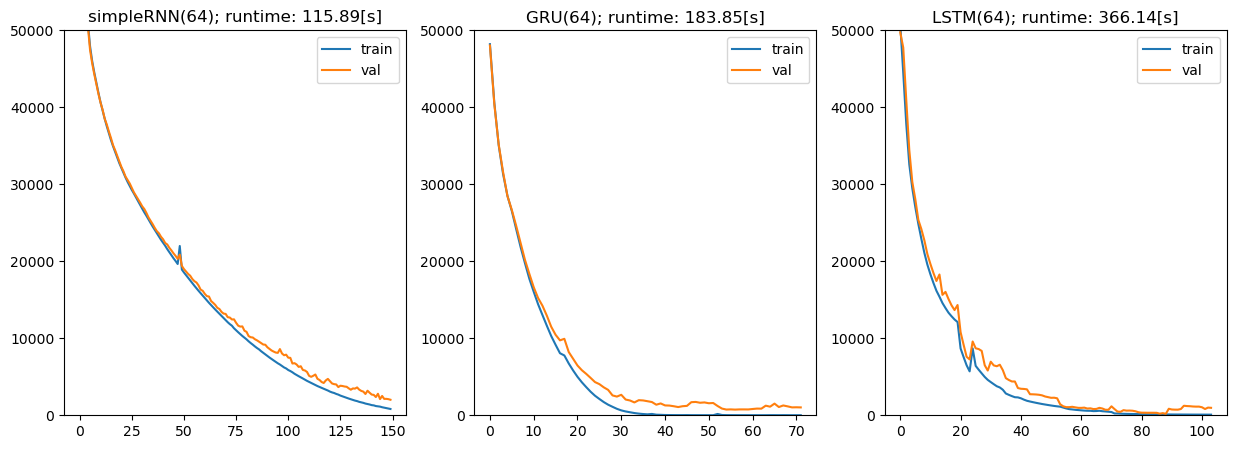

In [49]:
fig, ax = plt.subplots(1,3, figsize=(15,5))

ax[0].plot(LSTM_train, label = "train")
ax[0].plot(LSTM_val, label = "val")
ax[0].set_title(f"simpleRNN(64); runtime: {laptime_simple}[s]")
ax[0].set_ylim(0,50000)
ax[0].legend()

ax[1].plot(GRU_train, label = "train")
ax[1].plot(GRU_val, label = "val")
ax[1].set_title(f"GRU(64); runtime: {laptime_GRU}[s]")
ax[1].set_ylim(0,50000)
ax[1].legend()

ax[2].plot(simple_train, label = "train")
ax[2].plot(simple_val, label = "val")
ax[2].set_title(f"LSTM(64); runtime: {laptime_LSTM}[s]")
ax[2].set_ylim(0,50000)
ax[2].legend()

#plt.savefig("compare_models.pdf")

# FINETUNING LSTM:

In [13]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1)


search_results = []

dense_candidates = [
   8,16,32,64
]
dropout_candidates = [
  .2,.3,.4
]
learning_rate_candidates = [
   .001,.002,.005
]
batch_candidates = [
   4, 8, 16
]
layer_candidates = [
    1,2,3
]

for learning in learning_rate_candidates:
    for nb_dense in dense_candidates:
        for dropout in dropout_candidates:
            for batches in batch_candidates:
                for layers in layer_candidates:

                    print(f"Start training for (learning={learning} - layers={layers}  - dense={nb_dense} - dropout={dropout} - batches={batches})")

                    ########################################
                    model = Sequential()

                    ac =  'LeakyReLU'

                    for i in range(layers):
                        if i > 0 :
                            model.add(SimpleRNN(nb_dense, input_shape=(40, 8), return_sequences=True))
                            model.add(Dropout(dropout))
                    model.add(SimpleRNN(nb_dense, input_shape=(40, 8)))
                    model.add(Dropout(dropout))


                    model.add(Dense(units=11, activation='softplus'))

                    model.compile(loss='mse', optimizer=optimizers.Adam(learning_rate=learning), metrics=['mae'])
                    ########################################

                    # we choose our best model as the one having the highest validation accuracy
                    filepath = f"LST_cnn_paramsearch_ly={layers}_dn={nb_dense}_do={dropout}_lr={learning}_batches={batches}.hdf5"
                    checkpoint = ModelCheckpoint(
                        filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='min'
                    )

                    fit_results = model.fit(
                    x=X_train,
                    y=y_train,
                    batch_size=batches,
                    # reduce number of epochs for speed reasons --> should be higher!
                    epochs = 150,
                    validation_data=(X_val, y_val),
                    callbacks=[checkpoint, early_stop],
                    verbose=0
                    )

                    # extract the best validation scores
                    best_val_epoch    = np.argmin(fit_results.history['val_mae'])
                    best_val_mae     = np.min(fit_results.history['val_mae'])
                    best_val_mae_loss = fit_results.history['val_loss'][best_val_epoch]

                    # get correct training accuracy
                    best_model = load_model(filepath)
                    best_val_mae_train_loss, best_val_mae_train_mae = best_model.evaluate(X_train, y_train)

                    # store results
                    search_results.append({
                      'layers': layers,
                      'nb_dense': nb_dense,
                      'dropout': dropout,
                      'learning_rate' : learning,
                      'batches' : batches,
                      'best_val_mae_train_mae': best_val_mae_train_mae,
                      'best_val_mae': best_val_mae,
                      'best_val_mae_train_loss': best_val_mae_train_loss,
                      'best_val_mae_loss': best_val_mae_loss,
                      'best_val_epoch': best_val_epoch
                    })

Start training for (learning=0.001 - layers=1  - dense=8 - dropout=0.2 - batches=4)
41/41 [==============================] - 0s 2ms/step - loss: 39797.1211 - mae: 39.8028
Start training for (learning=0.001 - layers=2  - dense=8 - dropout=0.2 - batches=4)
41/41 [==============================] - 0s 3ms/step - loss: 39879.3086 - mae: 39.9084
Start training for (learning=0.001 - layers=3  - dense=8 - dropout=0.2 - batches=4)
41/41 [==============================] - 0s 4ms/step - loss: 39931.6055 - mae: 40.1008
Start training for (learning=0.001 - layers=1  - dense=8 - dropout=0.2 - batches=8)
41/41 [==============================] - 0s 2ms/step - loss: 45139.1172 - mae: 45.8161
Start training for (learning=0.001 - layers=2  - dense=8 - dropout=0.2 - batches=8)
41/41 [==============================] - 0s 3ms/step - loss: 45077.2422 - mae: 45.6221
Start training for (learning=0.001 - layers=3  - dense=8 - dropout=0.2 - batches=8)
41/41 [==============================] - 0s 3ms/step - loss: 

41/41 [==============================] - 0s 2ms/step - loss: 18802.5059 - mae: 21.1449
Start training for (learning=0.001 - layers=3  - dense=64 - dropout=0.3 - batches=8)
41/41 [==============================] - 0s 3ms/step - loss: 18883.8965 - mae: 20.3615
Start training for (learning=0.001 - layers=1  - dense=64 - dropout=0.3 - batches=16)
41/41 [==============================] - 0s 1ms/step - loss: 26940.3027 - mae: 27.5466
Start training for (learning=0.001 - layers=2  - dense=64 - dropout=0.3 - batches=16)
41/41 [==============================] - 0s 2ms/step - loss: 26981.1875 - mae: 27.1933
Start training for (learning=0.001 - layers=3  - dense=64 - dropout=0.3 - batches=16)
41/41 [==============================] - 0s 3ms/step - loss: 26869.9492 - mae: 27.0571
Start training for (learning=0.001 - layers=1  - dense=64 - dropout=0.4 - batches=4)
Epoch 143: early stopping
41/41 [==============================] - 0s 1ms/step - loss: 15028.4268 - mae: 18.3744
Start training for (lear

41/41 [==============================] - 0s 3ms/step - loss: 27445.4023 - mae: 28.2126
Start training for (learning=0.002 - layers=1  - dense=64 - dropout=0.2 - batches=4)
41/41 [==============================] - 0s 2ms/step - loss: 980.8503 - mae: 6.9514
Start training for (learning=0.002 - layers=2  - dense=64 - dropout=0.2 - batches=4)
41/41 [==============================] - 1s 2ms/step - loss: 940.9029 - mae: 7.0152
Start training for (learning=0.002 - layers=3  - dense=64 - dropout=0.2 - batches=4)
41/41 [==============================] - 0s 3ms/step - loss: 1509.5797 - mae: 8.4330
Start training for (learning=0.002 - layers=1  - dense=64 - dropout=0.2 - batches=8)
41/41 [==============================] - 0s 2ms/step - loss: 6462.3599 - mae: 12.2169
Start training for (learning=0.002 - layers=2  - dense=64 - dropout=0.2 - batches=8)
41/41 [==============================] - 0s 2ms/step - loss: 5906.7241 - mae: 11.8301
Start training for (learning=0.002 - layers=3  - dense=64 - dro

41/41 [==============================] - 0s 2ms/step - loss: 22136.6504 - mae: 27.5022
Start training for (learning=0.005 - layers=3  - dense=8 - dropout=0.4 - batches=4)
41/41 [==============================] - 0s 3ms/step - loss: 22914.4062 - mae: 29.2210
Start training for (learning=0.005 - layers=1  - dense=8 - dropout=0.4 - batches=8)
41/41 [==============================] - 0s 1ms/step - loss: 26426.5371 - mae: 27.0891
Start training for (learning=0.005 - layers=2  - dense=8 - dropout=0.4 - batches=8)
41/41 [==============================] - 0s 2ms/step - loss: 26980.1152 - mae: 27.9310
Start training for (learning=0.005 - layers=3  - dense=8 - dropout=0.4 - batches=8)
41/41 [==============================] - 1s 3ms/step - loss: 27796.0215 - mae: 30.5389
Start training for (learning=0.005 - layers=1  - dense=8 - dropout=0.4 - batches=16)
41/41 [==============================] - 0s 1ms/step - loss: 32683.7480 - mae: 32.6308
Start training for (learning=0.005 - layers=2  - dense=8 

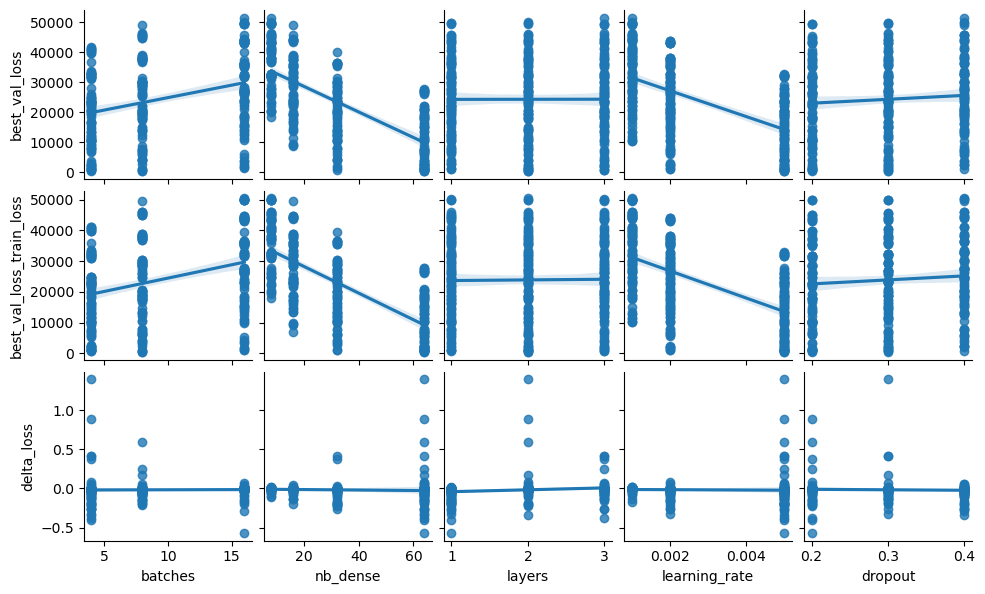

In [36]:
resultsDF['delta_loss'] = (resultsDF['best_val_loss_train_loss']-resultsDF['best_val_loss'])/resultsDF['best_val_loss']
sns.pairplot(resultsDF, x_vars=['batches', 'nb_dense' , 'layers', 'learning_rate' , 'dropout'], y_vars=['best_val_loss', 'best_val_loss_train_loss', 'delta_loss'], kind='reg',  height=2)
#plt.title("Gridsearch Hyperparameters Result")
plt.savefig("grid_search1.pdf")

In [41]:
resultsDF = pd.DataFrame(search_results)

# sort values
resultsDF = resultsDF.rename(columns={"best_val_mae_loss": "best_val_loss", "best_val_mae_train_loss": "best_val_loss_train_loss"})
resultsDF = resultsDF.sort_values('best_val_loss', ascending=True)
resultsDF.head(5)

,layers,nb_dense,dropout,learning_rate,batches,best_val_mae_train_mae,best_val_mae,best_val_loss_train_loss,best_val_loss,best_val_epoch
301,2,64,0.2,0.005,8,6.307665,4.993853,390.146729,244.596573,135
307,2,64,0.3,0.005,4,8.689884,6.171397,1119.690186,467.970978,92
310,2,64,0.3,0.005,8,6.820852,6.264912,556.710938,477.608124,126
298,2,64,0.2,0.005,4,10.660253,6.181417,975.801147,518.952271,97
308,3,64,0.3,0.005,4,8.314013,6.522310,838.901123,596.157043,102


# evaluating gridsearch:
Best model picked (third place)
- 2 	64 	0.3 	0.005 	

next: rebuild model with found parameters, implement learning schedualer


In [40]:
X = x
Y = y

scaler = RobustScaler(quantile_range=(25, 75))
scaler2 = StandardScaler()
scaler3 = MinMaxScaler(feature_range=(-10, 10))
#X = scaler.fit_transform(X)
#X = scaler2.fit_transform(X.reshape(-1, X.shape[-1])).reshape(X.shape)

scaler_y = MinMaxScaler(feature_range=(0.1, 0.9))  # feature range just for trying things out
#Y = scaler2.fit_transform(Y)
Y = scaler_y.fit_transform(Y)


X_train, X_test, y_train, y_test = train_test_split(X, Y,  test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,  test_size=0.2, random_state=1)

X_test = scaler2.fit_transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)
X_train = scaler2.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_val = scaler2.fit_transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape)


In [41]:
early_stop = EarlyStopping(monitor='val_loss', patience=20, verbose=1)
learning = tf.keras.callbacks.LearningRateScheduler(scheduler)

model = Sequential()

# found hyper parameters
layers = 2 
nb_dense  = 64
dropout = 0.3
learning_rate  = 0.005
batches = 8

optimizer = Adam(learning_rate=learning_rate)

model.add(SimpleRNN(nb_dense, input_shape=(40, 8), return_sequences=True))
model.add(Dropout(dropout))
model.add(SimpleRNN(nb_dense, input_shape=(40, 8)))
model.add(Dropout(dropout))

model.add(Dense(units=11, activation= 'tanh'))

train_hist=HistoryEpoch((X_train, y_train))
val_hist=HistoryEpoch((X_val, y_val))
test_hist=HistoryEpoch((X_test, y_test))

model.compile(loss='mse', optimizer=optimizer, metrics=['mae'])
model.build(X_train.shape)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_4 (SimpleRNN)    (None, 40, 64)            4672      
                                                                 
 dropout_4 (Dropout)         (None, 40, 64)            0         
                                                                 
 simple_rnn_5 (SimpleRNN)    (None, 64)                8256      
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 11)                715       
                                                                 
Total params: 13,643
Trainable params: 13,643
Non-trainable params: 0
_________________________________________________________________


In [42]:
starttime = time.time()
history_dropout = model.fit(X_train,y_train,
                                    batch_size=batches, epochs = 150, verbose=1,
                                    validation_data=(X_val, y_val),
                                    callbacks=[val_hist, train_hist, test_hist, early_stop, learning])
laptime_simple = round((time.time() - starttime), 2)
print(laptime_simple)

Epoch 1/150
161/161 [==============================] - 2s 9ms/step - loss: 0.1443 - mae: 0.2950 - val_loss: 0.0101 - val_mae: 0.0808 - lr: 0.0050
Epoch 2/150
161/161 [==============================] - 1s 8ms/step - loss: 0.0099 - mae: 0.0740 - val_loss: 0.0032 - val_mae: 0.0388 - lr: 0.0050
Epoch 3/150
161/161 [==============================] - 1s 8ms/step - loss: 0.0043 - mae: 0.0481 - val_loss: 0.0053 - val_mae: 0.0561 - lr: 0.0050
Epoch 4/150
161/161 [==============================] - 1s 8ms/step - loss: 0.0039 - mae: 0.0462 - val_loss: 0.0033 - val_mae: 0.0404 - lr: 0.0050
Epoch 5/150
161/161 [==============================] - 1s 8ms/step - loss: 0.0033 - mae: 0.0418 - val_loss: 0.0026 - val_mae: 0.0327 - lr: 0.0050
Epoch 6/150
161/161 [==============================] - 1s 8ms/step - loss: 0.0032 - mae: 0.0414 - val_loss: 0.0048 - val_mae: 0.0464 - lr: 0.0050
Epoch 7/150
161/161 [==============================] - 1s 8ms/step - loss: 0.0034 - mae: 0.0421 - val_loss: 0.0028 - val_mae

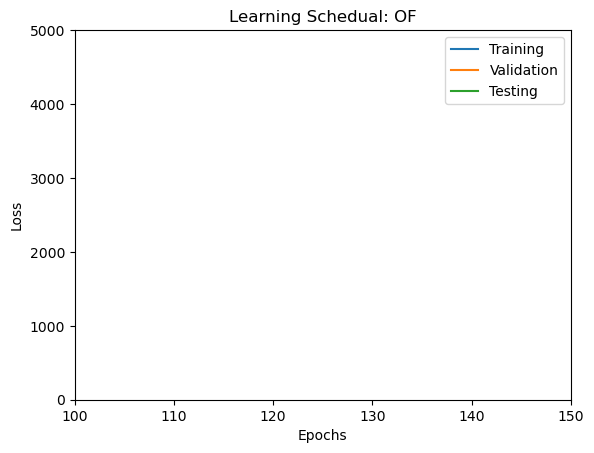

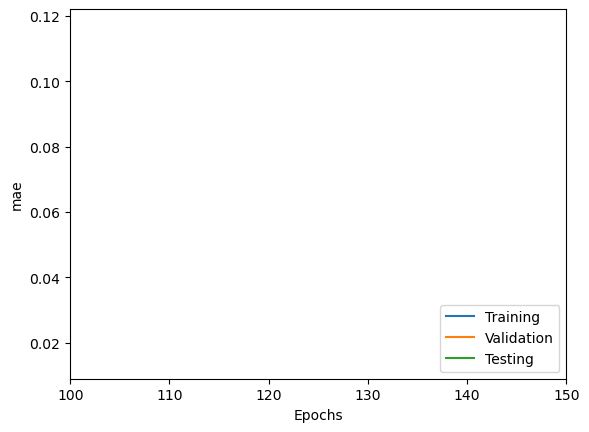

In [43]:
plt.figure()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(train_hist.loss)
plt.plot(val_hist.loss)
plt.plot(test_hist.loss)
plt.title("Learning Schedual: OF")
plt.legend(['Training', 'Validation', 'Testing'])
plt.ylim(0,5000)
plt.xlim(100,150)
#plt.savefig("learning_of.pdf")

plt.figure()
plt.xlabel('Epochs')
plt.ylabel('mae')
plt.plot(train_hist.acc)
plt.plot(val_hist.acc)
plt.plot(test_hist.acc)
plt.xlim(100,150)
plt.legend(['Training', 'Validation', 'Testing'], loc='lower right')
plt.show()

In [44]:
loss_and_metrics = model.evaluate(X_test, y_test, batch_size=1)
print(loss_and_metrics)

print('Testing...')
y_pred = model.predict(X_test, verbose = True, batch_size=1)

#plt.plot(X_val[:,0], y_pred, "ro", alpha  = 0.4, label  = "pred")
#plt.plot(X_val[:,0], y_val, "bx", alpha=1,label  = "test")
#plt.legend()



401/401 [==============================] - 1s 2ms/step - loss: 0.0041 - mae: 0.0409
[0.004058650229126215, 0.04085174575448036]
Testing...
401/401 [==============================] - 1s 2ms/step


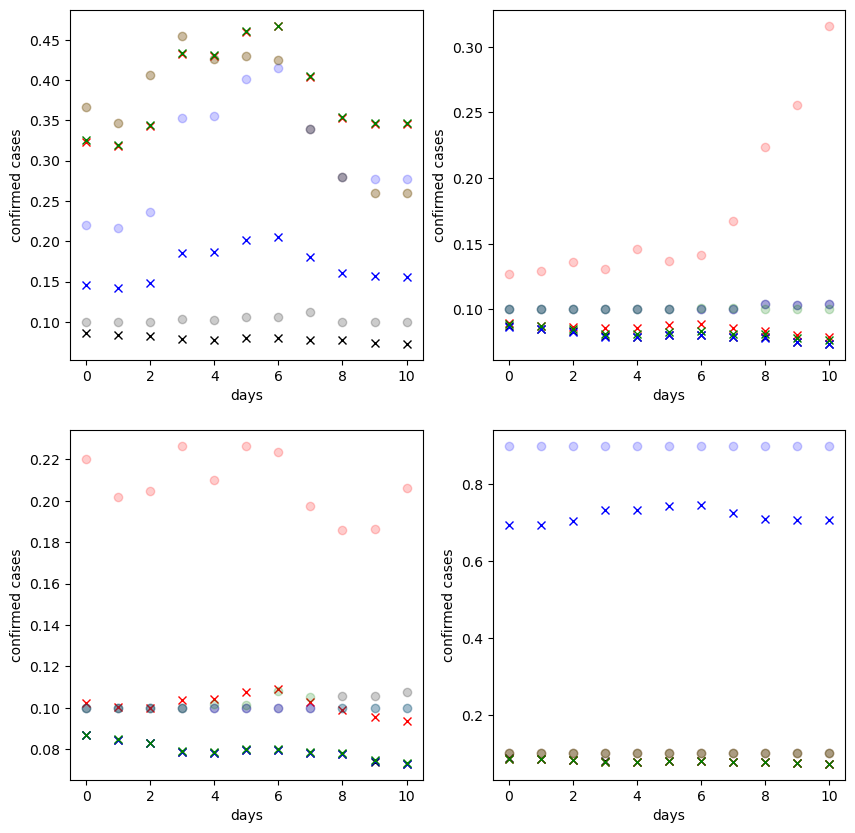

In [45]:
x = np.arange(0,11)

fig, ax = plt.subplots(2,2 , figsize = (10,10))

for m in range(2):
    for n in range(2):
        i = (m*8+n*4)+9
        ax[m,n].plot(x,y_pred[i], "kx")
        ax[m,n].plot(x,y_test[i], "ko", alpha = 0.2)
        ax[m,n].set_xlabel("days")
        ax[m,n].set_ylabel("confirmed cases")

        
        i = (m*8+n*4)+10
        ax[m,n].plot(x,y_pred[i], "rx")
        ax[m,n].plot(x,y_test[i], "ro", alpha = 0.2)

        i = (m*8+n*4)+11
        ax[m,n].plot(x,y_pred[i], "bx")
        ax[m,n].plot(x,y_test[i], "bo", alpha = 0.2)

        i = (m*8+n*4)+12
        ax[m,n].plot(x,y_pred[i], "gx")
        ax[m,n].plot(x,y_test[i], "go", alpha = 0.2)

#plt.savefig("results.pdf")

In [29]:
model.save('FINAL_MODEL.hdf5')